# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
- opens all CMIP6 historical model run files with data on surface temperature tas
- opens ERSST observational dataset with sst sea surface temperature 
- calculates the Nino3.4 index for the data to test the ENSO state in the months before and after Krakatoa 1883


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5/

v20200302


In [5]:
!ls /g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc

/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc


In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [10]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [11]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Read in obs data

In [13]:
# read in obs data from ersst dataset 
ersst_path = '/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.r240x120.nc'
ersst = xr.open_dataset(ersst_path)
if 'time_bnds' in ersst:
    del ersst['time_bnds']
ersst

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 240, time: 1989)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-09-01
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    history:                   Thu Dec 03 18:13:58 2020: cdo remapcon,r240x12...
    source:                    In situ data: ICOADS R3.0 before 2015, NCEP in...
    institution:               This version written at NOAA/ESRL PSD: obtaine...
    Conventions:               CF-1.6, ACDD-1.3
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0
    geospatial_laty_max:       89.0
    geospatial_laty_min:       -89.0
    geospatial_lat_max:        89.0
    geospatial_lat_min:        -89.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    cdm_data_type:             Grid
    project:                   NOAA Extended Reconstructed Sea Surface Temper...
    original_publisher_url:    http://www.ncdc.noaa.gov
    References:                https://www.ncdc.noaa.gov/data-access/marineoc...
    title:                     NOAA ERSSTv5 (in situ only)
    citation:                  Huang et al, 2017: Extended Reconstructed Sea ...
    platform:                  Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    standard_name_vocabulary:  CF Standard Name Table (v40, 25 January 2017)
    processing_level:          NOAA Level 4
    metadata_link:             :metadata_link = https://doi.org/10.7289/V5T72...
    creator_name:              Boyin Huang (original)
    date_created:              2017-06-30T12:18:00Z (original)
    product_version:           Version 5
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2019-10-03
    CDO:                       Climate Data Operators version 1.9.8 (https://...

In [14]:
# convert to month end frequency (rahter than month start)
ersst = ersst.resample(time = 'M').mean()

## Area weighting
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [15]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

In [16]:
ersst_w = ersst*np.cos(ersst.lat*(np.pi/180))

## Nino 3.4

In [17]:
# add the multi-model mean to the data-array
# models_w_mmm = func.add_mmm(models_w)

# calculate the multi-model mean
mmm = models_w.mean(dim='model')

In [18]:
# calculate the nino3.4 index for all models for every month divided by std
nino34_index = func.nino34(models_w, '1850-01', '1880-01', 1)

In [19]:
# calculate the nino3.4 index for multi-model mean for every month divided by std
nino34_mmm = func.nino34(mmm, '1850-01', '1880-01', 1)

In [20]:
func=reload(func)

In [21]:
# calculate the nino3.4 index for obs data for every month
nino34_obs = func.nino34(ersst_w, '1850-01', '1880-01', 0)

### Threshold

In [22]:
# set the threshold for el nino/la nia events
THOLD = 0.4

# Graphs

In [23]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

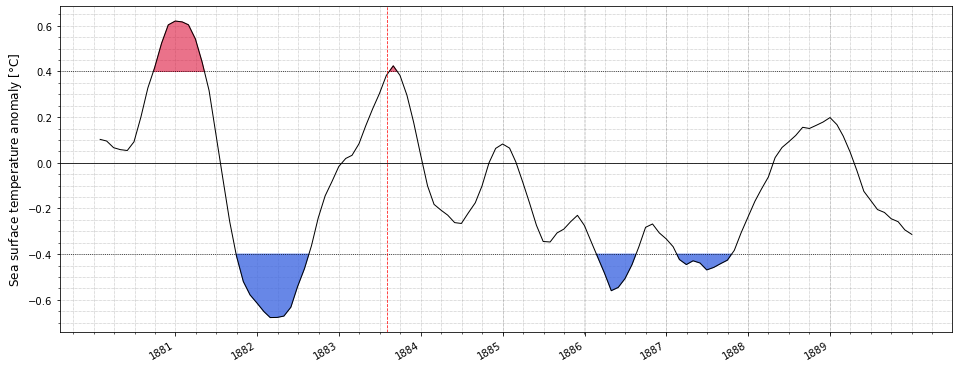

In [24]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_mmm.ts.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

#plt.savefig('nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

<AxesSubplot:ylabel='Sea surface temperature anomaly [$\\degree$C]'>

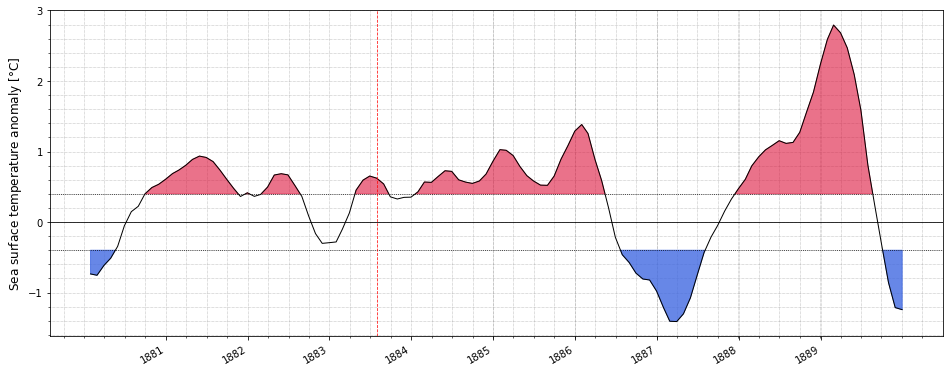

In [25]:
# plot time series of nino3.4 index for the obs ERSST dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_obs.sst.sel(time=slice('1880-01','1889-12')), e_date, THOLD, ax = axes)

#plt.savefig('nino34_plot_obs.png', dpi=300, bbox_inches='tight')

## next i want to classify each year as either el nino, la nino or neutral and then plot the results in a table 
to do this i need to count the number of el nino/la nina/ neutral events each year 
record count of dominant event for the year
then write the count and colour code (red el nino, blue la nina, white/grey neutral)  

In [26]:
# select out the years near the eruption
nino34_obs = nino34_obs.sel(time=slice('1883-01','1888-12'))
nino34_index = nino34_index.sel(time=slice('1883-01','1888-12'))

In [27]:
# add model dimension to obs dataset
ds = []
ds.append(nino34_obs)
obs = xr.concat(ds, dim='model', coords = 'minimal')
obs.coords['model'] = [' ERSST Observations']
# rename sst variable to ts so we can concat the datasets
obs = obs.rename_vars({'sst': 'ts'})

In [28]:
# append the obs to the rest of the anomaly array
ds2=[]
ds2.append(nino34_index)
ds2.append(obs)
nino34_index = xr.concat(ds2, dim='model', coords = 'minimal', compat='override')

# Produce a table showing onset date of el nino events (anomalies above threshold that last longer than 5 months) 

In [29]:
func = reload(func)

In [30]:
# find the nino/nina events over the specified threshold and lasting longer than 5 months
ENSO_events_04 = func.find_ENSO(nino34_index, 0.4)

In [72]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1882
jun83 = '1883-06-30' ; jul83 = '1883-07-31';  aug83 = '1883-08-31'
func.ENSO_sel(ENSO_events_04, jun83, jul83, aug83)

16 models record an El Nino in  1883-06-30 - 1883-08-31:
[' ERSST Observations' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'CAMS-CSM1-0'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CanESM5' 'E3SM-1-1-ECA' 'EC-Earth3'
 'FGOALS-f3-L' 'FGOALS-g3' 'GFDL-ESM4' 'GISS-E2-1-G-CC' 'GISS-E2-1-H'
 'MIROC6' 'NorCPM1']
9 models record a La Nina in  1883-06-30 - 1883-08-31:
['AWI-ESM-1-1-LR' 'CMCC-CM2-SR5' 'EC-Earth3-AerChem' 'FIO-ESM-2-0'
 'GFDL-CM4' 'GISS-E2-1-G' 'MRI-ESM2-0' 'NESM3' 'NorESM2-MM']


In [70]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1883
dec83 = '1883-12-31' ; jan84 = '1884-01-31';  feb84 = '1884-02-29'
func.ENSO_sel(ENSO_events_04, dec83, jan84, feb84)

10 models record an El Nino in  1883-12-31 - 1884-02-29:
['BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2-FV2' 'E3SM-1-1' 'EC-Earth3'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'GFDL-ESM4' 'IITM-ESM']
12 models record a La Nina in  1883-12-31 - 1884-02-29:
['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-ESM-1-1-LR' 'CMCC-CM2-SR5'
 'EC-Earth3-AerChem' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'KACE-1-0-G'
 'MRI-ESM2-0' 'NESM3' 'NorESM2-MM']


In [58]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1884
dec84 = '1884-12-31' ; jan85 = '1885-01-31';  feb85 = '1885-02-28'
func.ENSO_sel(ENSO_events_04, dec84, jan85, feb85)

17 models record an El Nino in  1884-12-31 - 1885-02-28:
[' ERSST Observations' 'CESM2' 'CESM2-WACCM' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5'
 'EC-Earth3' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'GISS-E2-1-G'
 'GISS-E2-1-H' 'IITM-ESM' 'KACE-1-0-G' 'NESM3' 'NorESM2-LM' 'SAM0-UNICON'
 'TaiESM1']
12 models record a La Nina in  1884-12-31 - 1885-02-28:
['ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR' 'CAMS-CSM1-0'
 'CESM2-WACCM-FV2' 'E3SM-1-1-ECA' 'EC-Earth3-Veg-LR' 'FGOALS-f3-L'
 'GFDL-ESM4' 'GISS-E2-1-G-CC' 'MPI-ESM1-2-LR' 'NorESM2-MM']


In [65]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1885
dec85 = '1885-12-31' ; jan86 = '1886-01-31';  feb86 = '1886-02-28'
func.ENSO_sel(ENSO_events_04, dec85, jan86, feb86)

6 models record an El Nino in  1885-12-31 - 1886-02-28:
[' ERSST Observations' 'ACCESS-ESM1-5' 'CAS-ESM2-0' 'CESM2-WACCM-FV2'
 'CMCC-CM2-SR5' 'GISS-E2-1-G']
13 models record a La Nina in  1885-12-31 - 1886-02-28:
['CESM2' 'CMCC-CM2-HR4' 'E3SM-1-1' 'EC-Earth3-Veg-LR' 'FIO-ESM-2-0'
 'GFDL-CM4' 'GFDL-ESM4' 'IITM-ESM' 'KACE-1-0-G' 'MPI-ESM-1-2-HAM'
 'MPI-ESM1-2-LR' 'NorCPM1' 'TaiESM1']


In [55]:
# find and print models that recorded an El Nino (and then La Nina) in DJF 1886
dec86 = '1886-12-31' ; jan87 = '1887-01-31';  feb87 = '1887-02-28'
func.ENSO_sel(ENSO_events_04, dec86, jan87, feb87)

8 models record an El Nino in  1886-12-31 - 1887-02-28:
['ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'CAMS-CSM1-0' 'CESM2-WACCM'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'NorESM2-MM' 'SAM0-UNICON']
16 models record a La Nina in  1886-12-31 - 1887-02-28:
[' ERSST Observations' 'ACCESS-CM2' 'BCC-CSM2-MR' 'BCC-ESM1' 'CAS-ESM2-0'
 'CESM2' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CanESM5' 'EC-Earth3'
 'GFDL-ESM4' 'GISS-E2-1-H' 'IITM-ESM' 'MRI-ESM2-0' 'NorCPM1' 'TaiESM1']


AttributeError: 'DataFrame' object has no attribute 'sel'

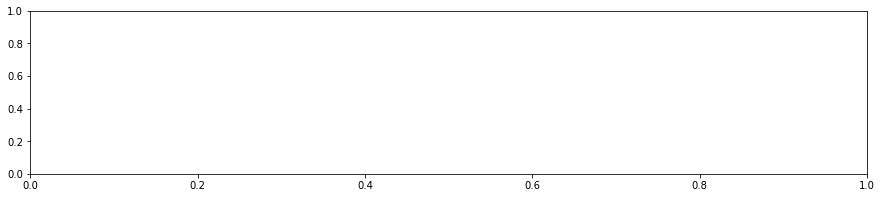

In [68]:
# plot the few models in a table 
fig, ax = plt.subplots(1, figsize=(15,3))

# set the bbox (figure height and width)
# y0_h = 0.44 # sets the start/base of the header height
# y1_h = 0.12 # sets the header height
# y0 = -0.5 # sets the base of main table height??
# y1 = 1 # sets the main table height (and therefore height of each cell)
y0_h = 1.3 # sets the start/base of the header height
y1_h = 0.2 # sets the header height
y0 = 0 # sets the base of main table height??
y1 = 1.4 # sets the main table height (and therefore height of each cell)

# call function to make the table, use loc to select out the models in the ds ENSO_good_models
func2.nino34_table(ENSO_events_04.loc[ENSO_good_models.model], y0_h, y1_h, y0, y1)

# save table as pdf 
plt.savefig('nino3.4_table_selected_0.4thold.png', dpi=300, bbox_inches='tight')

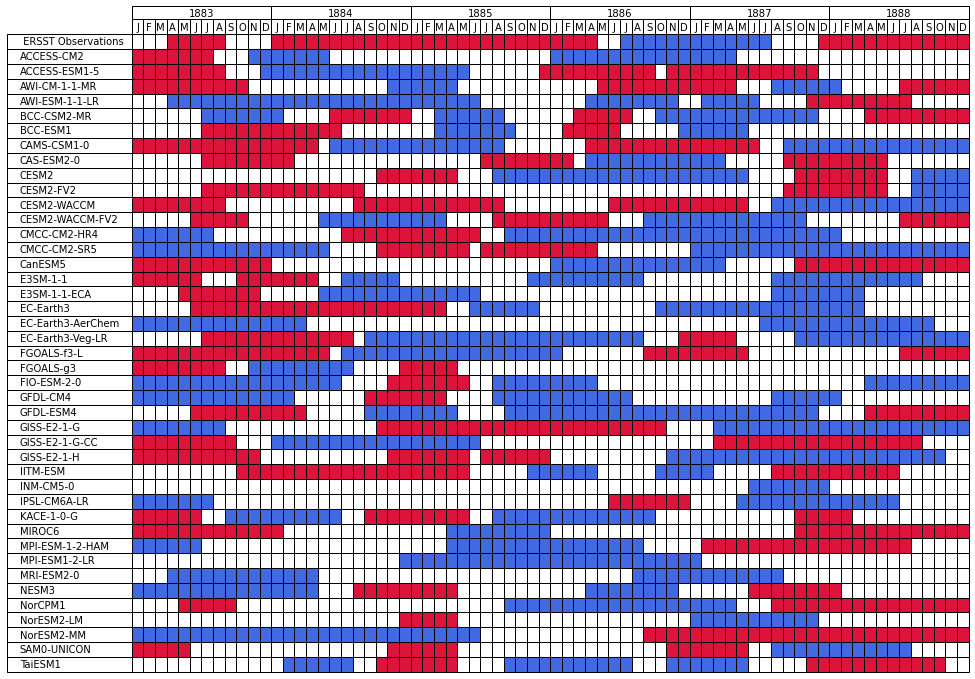

In [57]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,8))

# set the bbox (figure height and width)
y0_h = 0.97 # sets the start/base of the header height
y1_h = 0.06 # sets the header height
y0 = -0.5 # sets the base of main table height??
y1 = 1.5 # sets the main table height (and therefore height of each cell)
# call function to make the table
func2.nino34_table(ENSO_events_04, y0_h, y1_h, y0, y1)

# save table as pdf 
plt.savefig('nino3.4_table_0.4thold.png', dpi=300, bbox_inches='tight')

# now that I have found the models that do an ok job of ENSO I nee to redo SEA anomalies and maybe tables
# but can probs do this in another notebook